<a href="https://colab.research.google.com/github/tleyden/FruitPunch_AI_Bootcamp/blob/main/FruitPunch_Capstone_Project_YOLO_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pip installs

In [1]:
!apt install -y jq
!pip install pycocotools
!python -m pip install pyyaml==5.1
!pip install wandb -qU


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libjq1 libonig4
The following NEW packages will be installed:
  jq libjq1 libonig4
0 upgraded, 3 newly installed, 0 to remove and 20 not upgraded.
Need to get 276 kB of archives.
After this operation, 930 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libonig4 amd64 6.7.0-1 [119 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libjq1 amd64 1.5+dfsg-2 [111 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 jq amd64 1.5+dfsg-2 [45.6 kB]
Fetched 276 kB in 0s (554 kB/s)
Selecting previously unselected package libonig4:amd64.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../libo

## Imports

In [2]:
import os
from matplotlib import pyplot as plt
import cv2

from pycocotools.coco import COCO
import skimage.io as io
from pathlib import Path

import sys, distutils.core
from google.colab.patches import cv2_imshow
import json
import shutil
import yaml

## Weights and biases setup

In [3]:
import wandb
wandb.login() 

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Mount google drive

In [4]:
# Mount google drive
from google.colab import drive
drive.mount("/content/drive")
     

Mounted at /content/drive


## Download zips from google bucket

In [5]:
from google.colab import auth
auth.authenticate_user()

if not os.path.exists("Labeled data-20211126T095740Z-001.zip"):
    !gsutil cp "gs://fruitpunch-ai-tleyden/Labeled data-20211126T095740Z-001.zip" .
if not os.path.exists("Labeled data-20211126T095740Z-002.zip"):
    !gsutil cp "gs://fruitpunch-ai-tleyden/Labeled data-20211126T095740Z-002.zip" .


Copying gs://fruitpunch-ai-tleyden/Labeled data-20211126T095740Z-001.zip...
\ [1 files][  2.0 GiB/  2.0 GiB]   64.3 MiB/s                                   
Operation completed over 1 objects/2.0 GiB.                                      
Copying gs://fruitpunch-ai-tleyden/Labeled data-20211126T095740Z-002.zip...
\ [1 files][809.6 MiB/809.6 MiB]   72.6 MiB/s                                   
Operation completed over 1 objects/809.6 MiB.                                    


In [6]:
if not os.path.exists("labeled_data"):
    !unzip -q "Labeled data-20211126T095740Z-001.zip"
    !unzip -q "Labeled data-20211126T095740Z-002.zip"

## Re-arrange directories to match expected structure

In [16]:
if not os.path.exists("labeled_data"):
    os.makedirs("labeled_data")
    !mv "Labeled data" labeled_data
if not os.path.exists("labeled_data/images/test"):
    !mkdir labeled_data/images/test 
    !mv labeled_data/images/*.PNG labeled_data/images/test 

## Set some global variables

In [10]:
DATA_PATH = '/content/labeled_data/'


use_single_batch = False
if use_single_batch:
    # Smaller subset of dataset for faster iteration
    LABELS_PATH = DATA_PATH + 'annotations_single_batch/'
    IMAGES_PATH = DATA_PATH + 'images_single_batch/'
else:
    LABELS_PATH = DATA_PATH + 'annotations/'
    IMAGES_PATH = DATA_PATH + 'images/'

# Get paths to IMAGE directories
TRAIN_IMAGES_PATH = IMAGES_PATH + 'train/'
TEST_IMAGES_PATH = IMAGES_PATH + 'test/'
VAL_IMAGES_PATH = IMAGES_PATH + 'val/'

TRAIN_LABELS = LABELS_PATH + 'instances_train.json'
TEST_LABELS = LABELS_PATH + 'instances_test_dataset.json'
VAL_LABELS = LABELS_PATH + 'instances_val.json'



## Create single batch annotations

Create a smaller dataset that can be used for faster iteration/experimentation with hyperparameters.  After results are improved, then re-train on the entire data set.  This technique is suggested in [Andrej Karpathy's A Recipe for Training Neural Networks](http://karpathy.github.io/2019/04/25/recipe/)

In [ ]:
def create_single_batch_annotations(num_instances_to_collect):
    """
    Create a copy of annotations/instances_train.json, instances_test_dataset.json and instances_val.json
    in the annotations_single_batch directory with a smaller subset of annotations.
    """
    source_annotations = ["instances_train.json", "instances_test_dataset.json", "instances_val.json"]
    for source_annotation in source_annotations:
        subset_json = {}
        with open(os.path.join(DATA_PATH, "annotations", source_annotation), "r") as f:
            instances_json = json.loads(f.read())
        subset_json["licenses"] = instances_json["licenses"]
        subset_json["info"] = instances_json["info"]
        subset_json["categories"] = instances_json["categories"]
        subset_images = []
        subset_annotations = []
        collected_image_ids = []
        
        for annotation_json in instances_json["annotations"]:
            if len(subset_annotations) >= num_instances_to_collect:
                # We have collected enough
                break
            subset_annotations.append(annotation_json)
            collected_image_ids.append(annotation_json["image_id"])
            
        for image_json in instances_json["images"]:
            if image_json["id"] not in collected_image_ids:
                continue
            subset_images.append(image_json)

            # Copy image to target image dir
            if "test" in source_annotation:
                target_img_dir = "test"
            elif "train" in source_annotation:
                target_img_dir = "train"
            elif "val" in source_annotation:
                target_img_dir = "val"

            file_name = image_json["file_name"]
            source_img = os.path.join(DATA_PATH, "images", target_img_dir, file_name)
            target_img = os.path.join(DATA_PATH, "images_single_batch", target_img_dir, file_name)
            if not os.path.exists(target_img):
                os.link(source_img, target_img)


        print(f"For {source_annotation} collected {len(subset_annotations)} instances")
        subset_json["images"] = subset_images
        subset_json["annotations"] = subset_annotations

        # Write json to target dir
        source_annotation_full_path = os.path.join(DATA_PATH, "annotations_single_batch", source_annotation)
        with open(source_annotation_full_path, "w") as f:
            json.dump(subset_json, f)
        print(f"Wrote {source_annotation_full_path}")




In [ ]:
if use_single_batch:
    if not os.path.exists(os.path.join(DATA_PATH, "annotations_single_batch")):
        os.makedirs(os.path.join(DATA_PATH, "annotations_single_batch"))
    if not os.path.exists(os.path.join(DATA_PATH, "images_single_batch")):
        os.makedirs(os.path.join(DATA_PATH, "images_single_batch"))
        os.makedirs(os.path.join(DATA_PATH, "images_single_batch", "train"))
        os.makedirs(os.path.join(DATA_PATH, "images_single_batch", "test"))
        os.makedirs(os.path.join(DATA_PATH, "images_single_batch", "val"))

create_single_batch_annotations(64)

For instances_train.json collected 64 instances
Wrote /content/labeled_data/annotations_single_batch/instances_train.json
For instances_test_dataset.json collected 64 instances
Wrote /content/labeled_data/annotations_single_batch/instances_test_dataset.json
For instances_val.json collected 64 instances
Wrote /content/labeled_data/annotations_single_batch/instances_val.json


## Convert annotations from coco -> yolo format

In [13]:
!git clone https://github.com/ultralytics/JSON2YOLO.git  # clone repo
%pip install -qr JSON2YOLO/requirements.txt # install dependencies

# Add JSON2YOLO to sys modules path
import sys
sys.path.insert(0, "JSON2YOLO")

fatal: destination path 'JSON2YOLO' already exists and is not an empty directory.


In [14]:
from general_json2yolo import convert_coco_json

if use_single_batch:
    convert_coco_json('/content/labeled_data/annotations_single_batch')
else:
    convert_coco_json('/content/labeled_data/annotations')

Annotations /content/labeled_data/annotations/instances_test_dataset.json: 100%|██████████| 1900/1900 [00:00<00:00, 2204.94it/s]
Annotations /content/labeled_data/annotations/instances_train.json: 100%|██████████| 13111/13111 [00:04<00:00, 2730.26it/s]
Annotations /content/labeled_data/annotations/instances_val.json: 100%|██████████| 3278/3278 [00:00<00:00, 4233.58it/s]


## Copy images to yolo dir

In [17]:
if use_single_batch:
    imgs_source_dir = os.path.join("labeled_data", "images_single_batch")
else:
    imgs_source_dir = os.path.join("labeled_data", "images")

imgs_train = os.path.join(imgs_source_dir, "train")
imgs_test = os.path.join(imgs_source_dir, "test")
imgs_val = os.path.join(imgs_source_dir, "val")

# Slightly confusing since it actually puts the images into the 
# labels directory to keep them in a single directory (as expected by yolov5).  
# TODO: rename this directory to be clearer
imgs_target_dir = os.path.join("new_dir", "labels")
imgs_target_train =  os.path.join(imgs_target_dir, "train")
imgs_target_test =  os.path.join(imgs_target_dir, "test_dataset")
imgs_target_val =  os.path.join(imgs_target_dir, "val")

!cp {imgs_train}/*.PNG {imgs_target_train}/
!cp {imgs_test}/*.PNG {imgs_target_test}/
!cp {imgs_val}/*.PNG {imgs_target_val}/


## Create yolo data yaml file

In [18]:
yolo_data_yaml = {
    "nc": 1,
    "names": ["Human"],
    "train": ["/content/new_dir/labels/train"],
    "test": ["/content/new_dir/labels/test_dataset"],
    "val": ["/content/new_dir/labels/val"]
}

with open('data.yaml', 'w') as file:
    yaml.dump(yolo_data_yaml, file)

## Install yolo

In [19]:
if not os.path.exists("yolov5"):
    !git clone https://github.com/ultralytics/yolov5  # clone repo
    %pip install -qr yolov5/requirements.txt # install dependencies


Cloning into 'yolov5'...
remote: Enumerating objects: 14525, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 14525 (delta 22), reused 29 (delta 14), pack-reused 14477
Receiving objects: 100% (14525/14525), 13.70 MiB | 26.28 MiB/s, done.
Resolving deltas: 100% (9994/9994), done.
     |████████████████████████████████| 701 kB 6.4 MB/s 
     |████████████████████████████████| 1.6 MB 70.7 MB/s 


## Train yolo

In [ ]:
!python yolov5/train.py --img 640 --batch 24 --epochs 300 --data data.yaml --weights yolov5l.pt --cache


wandb: Currently logged in as: tleyden (eyepi). Use `wandb login --relogin` to force relogin
train: weights=yolov5l.pt, cfg=, data=data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=24, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-34-g1ae9194 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls

## Eval yolo

### Generate bbox predictions on test set


In [20]:
!python yolov5/detect.py --device 0 --weights best_model_colab.pt --source /content/new_dir/labels/test_dataset


detect: weights=['best_model_colab.pt'], source=/content/new_dir/labels/test_dataset, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-34-g1ae9194 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 267 layers, 46108278 parameters, 0 gradients, 107.6 GFLOPs
image 1/1900 /content/new_dir/labels/test_dataset/video82_1_000470.PNG: 480x640 (no detections), 42.9ms
image 2/1900 /content/new_dir/labels/test_dataset/video82_1_000471.PNG: 480x640 2 Humans, 35.2ms
image 3/1900 /content/new_dir/labels/test_dataset/video82_1_000472.PNG: 480x640 2 Humans, 35.2ms
image 4/1900 /content/new_

### Calculate mAP score on test set

In [21]:
!python yolov5/val.py --device 0 --weights best_model_colab.pt --data data.yaml

val: data=data.yaml, weights=['best_model_colab.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-34-g1ae9194 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 267 layers, 46108278 parameters, 0 gradients, 107.6 GFLOPs
100% 755k/755k [00:00<00:00, 32.1MB/s]
val: Scanning /content/new_dir/labels/val... 3278 images, 0 backgrounds, 0 corrupt: 100% 3278/3278 [00:07<00:00, 421.19it/s]
val: New cache created: /content/new_dir/labels/val.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 103/103 [01:29<00:00,  1.16it/s]
                   all       3278       8417      0.799      0.721      0.803      0.436
Speed: 0.2ms pre-process, 21.5ms i

### Display a few test predictions next to actual labels

Helper function to superimpose bounding boxes on an image given a yolo label file.

In [22]:
def superimpose_yolo_boxes(image_path, yolo_labelfile_path, classnames):
    """
    Return an image object with the yolo bounding boxes superimposed.
    
    :param classnames: a list of classnames.  The yolo labels will have the index, 
                       and indexing into classnames will give the actual classname 
                       (eg, "forklift")
    
    
    Steps:
    
    1. Load the image from the image path
    2. Load the yolo labels
    3. For each yolo label, draw a bounding box
    4. Return the image
    """
    
    image = cv2.imread(image_path)
    height, width, channels = image.shape
    line_thickness = round(0.002 * (image.shape[0] + image.shape[1]) / 2) + 1 
    
    with open(yolo_labelfile_path, "r") as yolo_labelfile:
        for line in yolo_labelfile:
            fields = line.split()
            class_label = classnames[int(fields[0])]
            
            normalized_x_center = float(fields[1])
            normalized_y_center = float(fields[2])
            normalized_w = float(fields[3])
            normalized_h = float(fields[4])
            
            x_center = normalized_x_center*width
            y_center = normalized_y_center*height
            w = normalized_w*width
            h = normalized_h*height                        
            
            xmin = round(x_center - w/2)  # Left
            ymin = round(y_center - h/2)  # Top
            xmax = round(x_center + w/2)  # Right
            ymax = round(y_center + h/2)  # Bottom  
                        
            color = [random.randint(0, 255) for _ in range(3)]

            top_left = (xmin, ymin)
            bottom_right = (xmax, ymax)
            cv2.rectangle(image, top_left, bottom_right, color, thickness=line_thickness, lineType=cv2.LINE_AA)
            
            # Shift the label down a few pixels if the bounding box is at the top of the image
            top_left_with_offset = top_left
            if ymin <= 20:
                top_left_with_offset = (xmin, ymin + 20)
            cv2.putText(image, str(class_label), top_left_with_offset, 0, line_thickness / 3, [225, 255, 255], thickness=line_thickness, lineType=cv2.LINE_AA)
            
        RGB_im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return RGB_im

Generate side by side images of actual predictions vs ground truth.  See screenshots in the project report for example output.

['video82_3_000502.PNG', 'video82_1_000803.PNG', 'video82_2_000718.PNG']
Help on method sample in module random:

sample(population, k) method of random.Random instance
    Chooses k unique random elements from a population sequence or set.
    
    Returns a new list containing elements from the population while
    leaving the original population unchanged.  The resulting list is
    in selection order so that all sub-slices will also be valid random
    samples.  This allows raffle winners (the sample) to be partitioned
    into grand prize and second place winners (the subslices).
    
    Members of the population need not be hashable or unique.  If the
    population contains repeats, then each occurrence is a possible
    selection in the sample.
    
    To choose a sample in a range of integers, use range as an argument.
    This is especially fast and space efficient for sampling from a
    large population:   sample(range(10000000), 60)

img_full_path: /content/new_dir/label

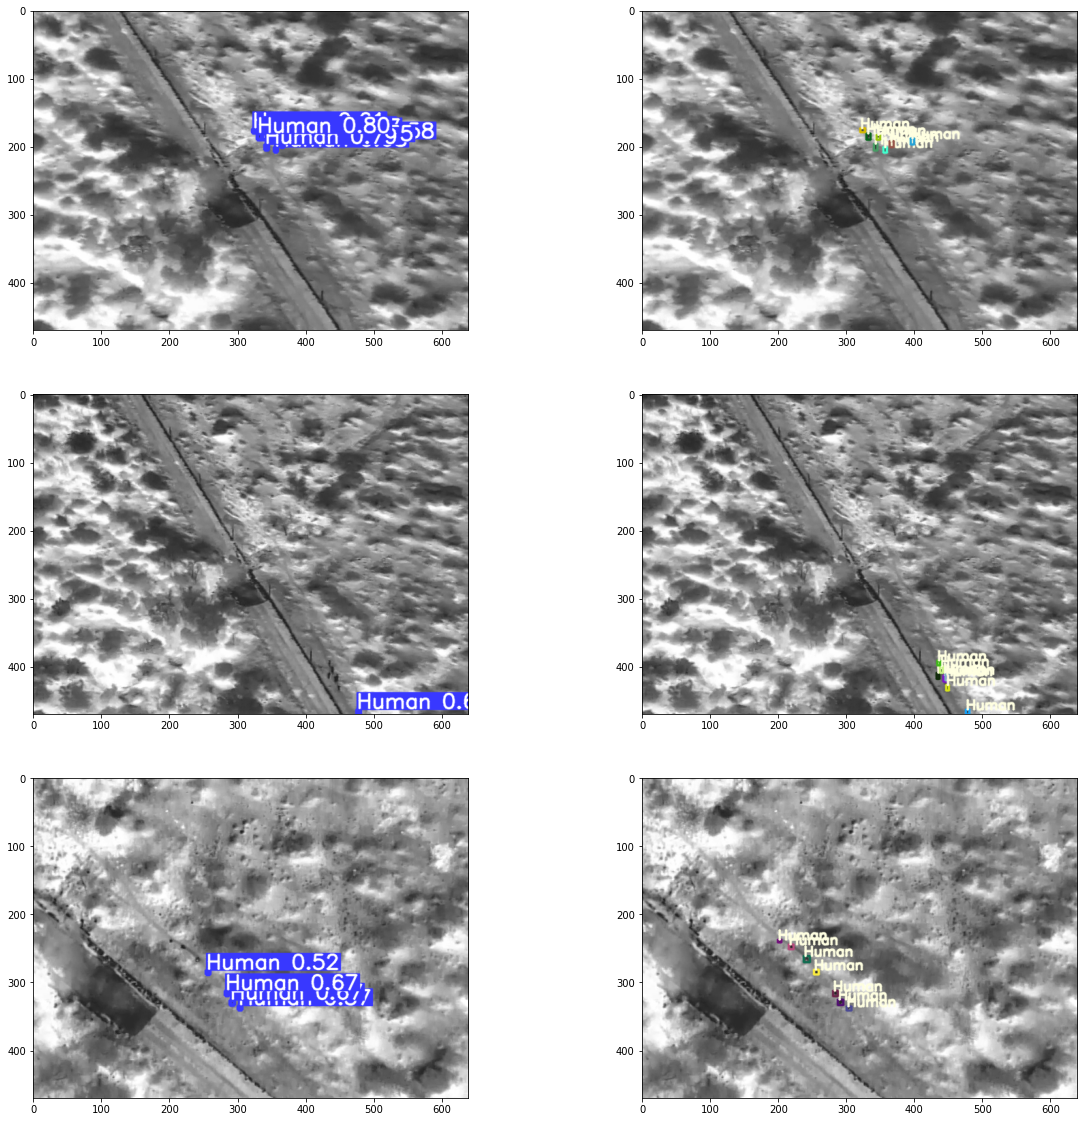

In [26]:
import random
test_predictions_path = "yolov5/runs/detect/exp"

# Get a few sample predicted images
all_images = os.listdir(test_predictions_path)
sampled_prediction_images = random.sample(all_images, 3)
print(sampled_prediction_images)
help(random.sample)

# Find the corresponding test images (non-superimposed bboxes) and their corresponding labels files
test_images_path = os.path.join("/content", "new_dir", "labels", "test_dataset")
unlabeled_test_images = []
label_files_for_test_images = []
for img in sampled_prediction_images:
    img_full_path = os.path.join(test_images_path, img)
    filename_no_extension = os.path.splitext(img)[0]
    yolo_label_file_full_path = os.path.join(test_images_path, f"{filename_no_extension}.txt")
    print(f"img_full_path: {img_full_path} yolo_label_file_full_path: {yolo_label_file_full_path}")
    unlabeled_test_images.append(img_full_path)
    label_files_for_test_images.append(yolo_label_file_full_path)
    

# Superimpose yolo labels on test images
# Plot them side by side with ground truth labeled test images
_, axs = plt.subplots(nrows=len(sampled_prediction_images), ncols=2, figsize=(20, 20))
for sampled_prediction_image, unlabeled_test_image, label_files_for_test_image, ax in zip(sampled_prediction_images, unlabeled_test_images, label_files_for_test_images, axs):
    print(f"Displaying image: {sampled_prediction_image}, {unlabeled_test_image}, {label_files_for_test_image} on ax: {ax}")
    superimposed_img = superimpose_yolo_boxes(
        image_path=unlabeled_test_image, 
        yolo_labelfile_path=label_files_for_test_image, 
        classnames=["Human"]
    )
    # print(f"superimposed_img: {superimposed_img}")
    sampled_prediction_image_full_path = os.path.join(test_predictions_path, sampled_prediction_image)
    sampled_prediction_image_cv2 = cv2.imread(sampled_prediction_image_full_path)
    ax[0].imshow(sampled_prediction_image_cv2)
    ax[1].imshow(superimposed_img)